In [2]:
#!pip install plotly-express
#!pip install nltk

In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import plotly.express as px
from matplotlib import pyplot as plt
import nltk
#nltk.download('stopwords') - Only have to run this once
#nltk.download('punkt') - Only have to run this once
from nltk.corpus import stopwords
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Notes
- If you get an "unread result" error just rerun the connect and cursor lines below

# Creating Connection
**Note: Update the connection information for your database**

In [2]:
mydb = mysql.connector.connect(host="127.0.0.1", user="root", password="mdionne12", database = "yelpdb") #Connecting to the local MySQL database

In [3]:
cursor = mydb.cursor()

# Business Dashboard

**Creating a dashboard that gives a business all useful information about their own reviews and the reviews from their nearby competitors.**

Plotting the stars recieved by the busiiness over time.

In [9]:
def business_dashboard(business_name : str, radius:float = 0.5):
    """
    This function provides all relevant information for the business dashboard for a given business_name.
    
    Inputs:
    business_name: name of business you are interested in 
    radius: distance from business(in miles) you want to see reviews for. If no radius is given, function will take 0.5 as a radius
    
    Outputs:
    - 
    """
    ##PART #1 - Review Summary
    #Query to pull number of reviews of business and the earliest and latest date reviews
    cursor.execute(f"SELECT COUNT(*) as num_reviews, min(date) as min_date, max(date) as max_date FROM yelpdb.reviews left join yelpdb.businesses ON \
                yelpdb.businesses.business_id = yelpdb.reviews.business_id where yelpdb.businesses.name='{business_name}';")
    result=cursor.fetchall() #Gathering the result

    #Converting results to dataframe 
    summ_stats = pd.DataFrame.from_dict(result) #Converting the dict results into a pandas dataframe
    summ_stats.rename(columns = {0:'num_reviews', 1:'min_date', 2:'max_date'}, inplace = True) # renaming columns in new data frame

    
    if summ_stats.loc[0,'num_reviews'] == 0: 
        print(f"{business_name} had a total of {summ_stats.loc[0,'num_reviews']} Yelp reviews")
        return #Exit the function if there are no reviews
    else:
        # Printing out statement showing num of reviews and earliest and latest review dates for buesiness chosen
        print(f"{business_name} had a total of {summ_stats.loc[0,'num_reviews']} Yelp reviews, with the first review on {summ_stats.loc[0,'min_date']} and the most recent review on {summ_stats.loc[0,'max_date']}")
    
    
    #--------------------------------------------------------------------------------------------
    ##PART #2 - Stars Histogram and Stars vs Time Graphs
    #Query to to get the stars and review date for a given business' reviews
    cursor.execute(f"SELECT yelpdb.reviews.stars, yelpdb.reviews.date FROM yelpdb.businesses RIGHT JOIN yelpdb.reviews ON \
                yelpdb.businesses.business_id = yelpdb.reviews.business_id WHERE yelpdb.businesses.name = '{business_name}'")
    result = cursor.fetchall() #Gathering the result
    
    stars_df = pd.DataFrame.from_dict(result) #Converting the dict results into a pandas dataframe
    stars_df.rename(columns = {0:'Stars', 1:'Date'}, inplace = True) #Renaming the columns
    stars_df.sort_values(['Date'], ascending = True, inplace = True) #Sorting by the oldest reviews first

    #Plotting histogram of the distribution of star reviews for a business
    fig2 = px.histogram(stars_df,x='Stars',title=f'Distribution of number of Stars Given to {business_name}')
    fig2.show()
    
    #Plotting a line plot of the number of stars the business has received over time
    fig2 = px.line(stars_df, x='Date', y="Stars", title = f'Number of Stars over Time to {business_name}')
    fig2.show()

    
    #--------------------------------------------------------------------------------------------
    ##PART #3 - Nearby Business Stars
    #Query to get the lat, long of the business - used after this
    cursor.execute(f"SELECT yelpdb.businesses.latitude, yelpdb.businesses.longitude FROM yelpdb.businesses WHERE yelpdb.businesses.name = '{business_name}'")
    result = cursor.fetchall() #Gathering the result
    latitude = result[0][0] #Saving the latitude for later
    longitude = result[0][1] #Saving the longitude for later
    
    #Using coordinates to find the n closest businesses to this business (pythagorean theorem used to find hypotenuse (distance)
    #Nested query makes sure that there are only n business that are merged with the reviews table, otherwise it merges n reviews for 1 business - don't want that
    #Creates temp table of the distance to nearby restaurants out of the businesses table, merges that with the reviews table and then grabs the business name, starts and distance
    cursor.execute(f"SELECT temp_table.name, yelpdb.reviews.stars, temp_table.distance, temp_table.business_id FROM (SELECT *, SQRT(POW((yelpdb.businesses.latitude - ({latitude})), 2) + POW((yelpdb.businesses.longitude - ({longitude})), 2)) AS distance \
                    FROM yelpdb.businesses) AS temp_table LEFT JOIN yelpdb.reviews ON temp_table.business_id = yelpdb.reviews.business_id WHERE (distance*69) < {radius}")
    result = cursor.fetchall() #Gathering the result

    #Creating and editing dataframe
    neighbors_df = pd.DataFrame.from_dict(result) #Convering the dict results into a pandas dataframe
    neighbors_df.rename(columns = {0:'Nearby Businesses', 1:'Average Stars', 2:'Distance (miles)', 3:'business_id'}, inplace = True) #Renaming the columns
    neighbors_df.drop(['business_id'], axis = 1, inplace = True) #Removing business_id from the table
    neighbors_df.sort_values(['Distance (miles)'], ascending = True, inplace = True) #Sorting by closest businesses first
    neighbors_df['Distance (miles)'] = neighbors_df['Distance (miles)']*69 #Converting distance to miles; 69 miles per degree

    print(f"There are {len(neighbors_df['Nearby Businesses'].unique())} businesses within {radius} miles of {business_name}\n") #Printing nearby businesses summary
    #Note: Not all businesses nearby will show if they don't have any reviews
    print(f"The following are business nearby {business_name} and reporting the number of stars that they have.")
    display(round(neighbors_df.dropna().groupby('Nearby Businesses', sort = False).mean(), 2).head(20))
    
    
    #--------------------------------------------------------------------------------------------
    ##PART #4 - Nearby Business Checkins vs Time
    #Using coordinates to find the n closest businesses to this business (pythagorean theorem used to find hypotenuse (distance)
    #Similar query to above, just merging with the checkin table now instead of the reviews table
    cursor.execute(f"SELECT temp_table.name, temp_table.distance, yelpdb.checkin.date FROM (SELECT *, SQRT(POW((yelpdb.businesses.latitude - ({latitude})), 2) + POW((yelpdb.businesses.longitude - ({longitude})), 2)) AS distance \
                    FROM yelpdb.businesses) as temp_table LEFT JOIN yelpdb.checkin ON temp_table.business_id = yelpdb.checkin.business_id WHERE (distance*69) < {radius}")
    result = cursor.fetchall() #Gathering the result

    #Creating and editing dataframe
    checkin_df = pd.DataFrame.from_dict(result) #Convering the dict results into a pandas dataframe
    checkin_df.rename(columns = {0:'Nearby Businesses', 1:'Distance (miles)', 2:'Checkins'}, inplace = True) #Renaming the columns
    checkin_df.sort_values(['Distance (miles)'], ascending = True, inplace = True)
    checkin_df['Distance (miles)'] = checkin_df['Distance (miles)']*69 #Converting distance to miles; 69 miles per degree

    
    #Note: Not all businesses nearby will show if they don't have any reviews
    #Grabbing the name of the nearest 10 restaurants
    names = list(checkin_df.dropna().groupby('Nearby Businesses', sort = False).count().head(10).index) #Grouping by business to get a list of the closest businesses

    checkin_df.sort_values(['Checkins'], ascending = True, inplace = True) #Sorting by the date of the checkin

    checkin_df['Count'] = checkin_df.groupby('Nearby Businesses').cumcount() #Getting the cummulative count of checkins for the business

    #Getting a dataframe of just the closest checkins
    closest_checkins_df = pd.DataFrame([])
    for i in names:
        temp_df = checkin_df.loc[checkin_df['Nearby Businesses'] == i]
        closest_checkins_df = closest_checkins_df.append(temp_df)
        
    #Plotting 
    fig = px.line(closest_checkins_df, x='Checkins', y='Count', color='Nearby Businesses', markers=True, title = 'Nearby Business Checkins vs Time', height=500, width=1050)
    fig.show()
    
    
    #--------------------------------------------------------------------------------------------
    ##PART #5 - Commonly Used Words
    #Finding commonly used words in the reviews
    #Getting the reviews for the business
    cursor.execute(f"SELECT yelpdb.reviews.text FROM yelpdb.businesses RIGHT JOIN yelpdb.reviews ON \
                yelpdb.businesses.business_id = yelpdb.reviews.business_id WHERE yelpdb.businesses.name = '{business_name}'")
    result = cursor.fetchall() #Gathering the result

    reviews = pd.DataFrame.from_dict(result) #Convering the dict results into a pandas dataframe
    reviews = reviews.rename(columns={0: 'text'}) #Renaming the column

    all_text = ' '.join(reviews['text'].tolist()) #Combine all reviews into a single string 

    # Convert all text to lowercase and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(all_text.lower())
    words_filtered = [word for word in words if word.isalnum() and word not in stop_words]


    # Count the frequency of each word and extract the most common
    word_counts = Counter(words_filtered)
    most_common_words = word_counts.most_common(30)

    most_common_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency']) # Convert the result to a Pandas DataFrame
    most_common_df = most_common_df.sort_values(by='Frequency', ascending=False) # Sort the DataFrame in descending order by frequency

    # Define the bar width and spacing
    bar_width = 0.5
    bar_spacing = 0.05

    # Draw a bar plot of the most common words
    plt.bar(most_common_df['Word'], most_common_df['Frequency'], width=bar_width, edgecolor='white', linewidth=1.5)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Most Common Words in Reviews for {business_name}')

    # Adjust the x-axis tick positions and labels
    plt.xticks([i + bar_spacing for i in range(len(most_common_df['Word']))], most_common_df['Word'])

    # Add grid lines and increase the figure size
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gcf().set_size_inches(12, 6)

    plt.show()

Sushi Rose had a total of 344 Yelp reviews, with the first review on 2011-03-24 02:01:15 and the most recent review on 2020-01-19 20:09:11


There are 120 businesses within 0.5 miles of Sushi Rose

The following are business nearby Sushi Rose and reporting the number of stars that they have.


Average Stars  Distance (miles)
Nearby Businesses                                              
Sushi Rose                               3.88              0.00
Fast Smog                                4.38              0.25
Jack in the Box                          2.86              0.38
Renown Lab Services - Mae Anne           3.80              0.40
Chili's                                  2.99              0.41
El Pollo Loco                            3.85              0.42
Banfield Pet Hospital                    4.12              0.42
Hacienda Restaurant & Bar                3.24              0.45

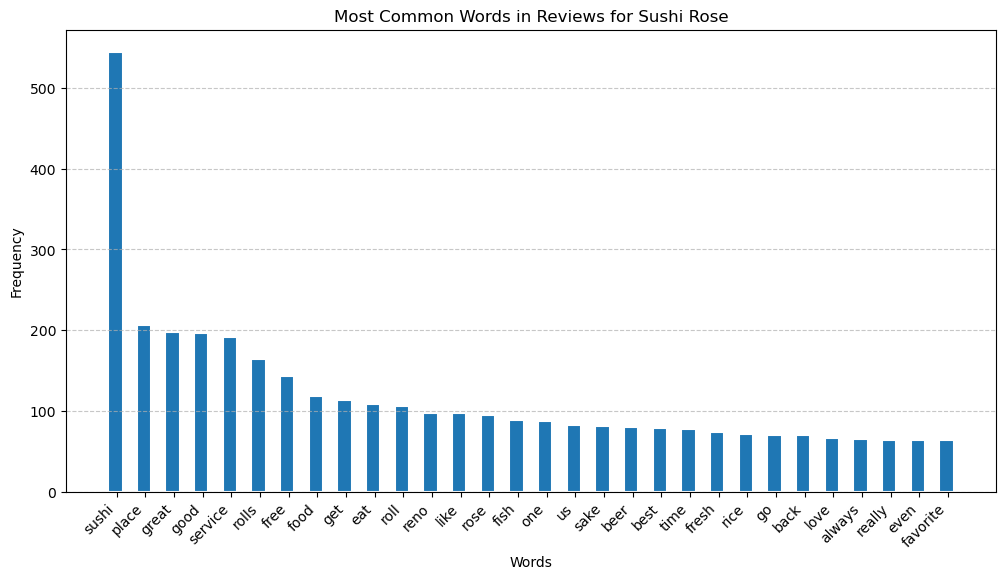

In [11]:
#You can try these too: "Bluewater Grill - Santa Barbara", "Cheu Noodle Bar", "Due Lune Cucina"
business_dashboard('Sushi Rose')